In [1]:
import numpy as np; np.set_printoptions(linewidth=150)
import torch; torch.set_printoptions(linewidth=150)
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
from environment import CliffWalk
from episodes import Episode, collect_episodes, monte_carlo_state_values, episodes_to_batch, episodes_to_masks, extract_monte_carlo_returns, beliefs_to_batch

In [3]:







# TD loss function
def td_loss(values, rewards, mask_traj, lengths, gamma=1.0):
    
    # calculate the TD target
    values_next = torch.zeros_like(values)
    values_next[:, :-1] = values[:, 1:]
    for b, l in enumerate(lengths): # TD target at last value should only be the reward
        values_next[b, l-1] = 0.0
    td_target = rewards + (gamma * values_next.detach())
    
    # Calculate the TD error
    td_error = ((values - td_target) ** 2) * mask_traj
    loss = td_error.sum() / mask_traj.sum()  # average loss over non-masked values
    
    return loss


def mc_loss(values, returns, mask_monte_carlo):
    # Compute the mc loss only at start and terminal states
    mc_values = values * mask_monte_carlo
    mc_returns = returns * mask_monte_carlo
    
    # Set first state return to the average of all first states
    start_state_return = mc_returns[:, 0].mean()
    mc_returns[:, 0] = start_state_return  

    mc_error = (mc_values - mc_returns) ** 2

    mc_loss = mc_error.sum() / mask_monte_carlo.sum()  # average loss over non-masked values

    return mc_loss

def evaluate_episode(model, episode):
    model.eval()  # switch to eval mode

    with torch.no_grad():
        history = torch.tensor(episode.history, dtype=torch.float32).unsqueeze(0)  # shape: [1, T, D]
        length = [history.shape[1]]  # length = [T]
        mask = torch.ones((1, history.shape[1]), dtype=torch.float32)

        predicted_values, _ = model(history, mask)  # shape: [1, T]
        return predicted_values.squeeze(0).numpy()  # shape: [T]
    
def validate(model, test_episode, value):
    true_values = test_episode.belief_states @ value
    true_values = np.round(true_values, 2)
    
    values = evaluate_episode(model, test_episode)
    values = np.round(values, 2)

    print("True Values:")
    print(true_values)
    print("Predicted Values:")
    print(values)
    plt.figure(figsize=(10, 5))
    plt.plot(true_values, label='True Values', marker='o')
    plt.plot(values, label='Predicted Values', marker='x')
    plt.title("True vs Predicted Values")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.show()






In [4]:
# Define the RNN-based value estimator
class ValueRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        
        # RNN to process the history of observations and actions
        self.rnn = nn.GRU(input_dim, hidden_dim, batch_first=True)
        
        # Head to output the value for each time step from the RNN output
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x, mask):
        hidden_states, _ = self.rnn(x)  # [B, T, H]
        
        # Calculate the output values for each time step
        values = self.head(hidden_states)  # [B, T, 1]
        values = values.squeeze(-1)  # [B, T]
        values = values * mask  # Apply the mask to the output

        return values, hidden_states
    
# Training loop
def train(model, episodes, test_episode, value=None, num_epochs=10, gamma=1.0, lr=1e-3, validate_every=500, batch_size=32):
    
    histories, rewards = episodes_to_batch(episodes)
    mask, mask_monte_carlo, lengths = episodes_to_masks(episodes)
    mc_returns = extract_monte_carlo_returns(rewards, mask, gamma)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)
    
    model.train()

    for epoch in range(num_epochs):
        # Validate sometimes
        if (epoch) % validate_every == 0:
            validate(model, test_episode, value)

        # choose "batch_size" random episodes from the dataset
        indices = np.random.choice(len(episodes), size=min(batch_size, len(episodes)), replace=False)
        batch_lengths = [lengths[i] for i in indices]

        # Calculate the estimated values
        optimizer.zero_grad()
        values, _ = model(histories[indices], mask[indices])  # shape: [B, T]
        
        # Calculate losses, and combine them
        td_L = td_loss(values, rewards[indices], mask[indices], batch_lengths, gamma)
        mc_L = mc_loss(values, mc_returns[indices], mask_monte_carlo[indices])
        loss = td_L + mc_L 
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print losses
        print(f"Epoch {epoch+1}, TD Loss: {np.sqrt(td_L.item()):.4f}, MC Loss: {np.sqrt(mc_L.item()):.4f}, Total: {np.sqrt(loss.item()):.4f}     ", end= '\r')
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}, TD Loss: {np.sqrt(td_L.item()):.4f}, MC Loss: {np.sqrt(mc_L.item()):.4f}, Total: {np.sqrt(loss.item()):.4f}")
        

Empirical Value function:
[[-11.94 -10.29  -8.04  -4.98]
 [-11.04  -9.29  -7.21  -2.84]
 [-12.12 -10.   -10.     0.  ]]


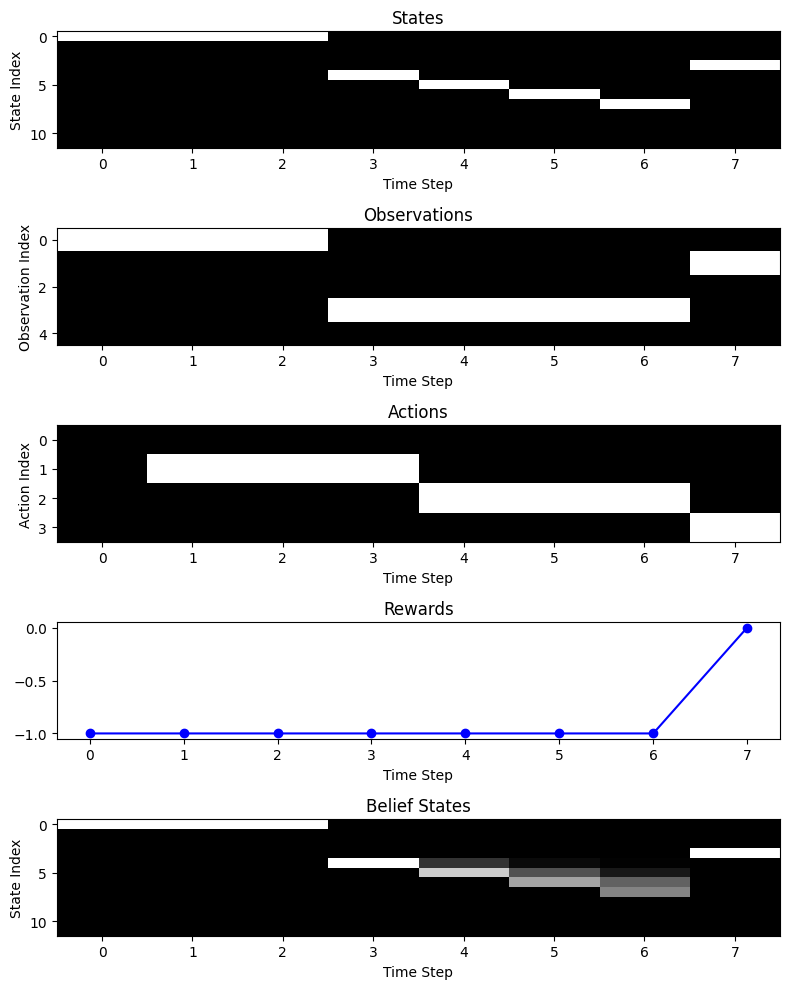

In [5]:
cliff = CliffWalk(n=3, m=4, self_transition_prob=0.2, gamma=1.0)
policy = cliff.get_optimal_policy(epsilon=0.3)

episodes = collect_episodes(cliff, policy, num_episodes=50000)

print("Empirical Value function:")
value_empirical = monte_carlo_state_values(episodes, gamma=cliff.gamma)
print(np.flip(value_empirical.reshape((cliff.n, cliff.m)), axis=0))

test_episode = collect_episodes(cliff, policy, num_episodes=1)[0]
#test_episode = episodes[0]
test_episode.render()

True Values:
[-12.12 -12.12 -12.12 -11.04  -9.64  -8.03  -5.2    0.  ]
Predicted Values:
[-0.06 -0.06 -0.06 -0.05 -0.05 -0.05 -0.05 -0.07]


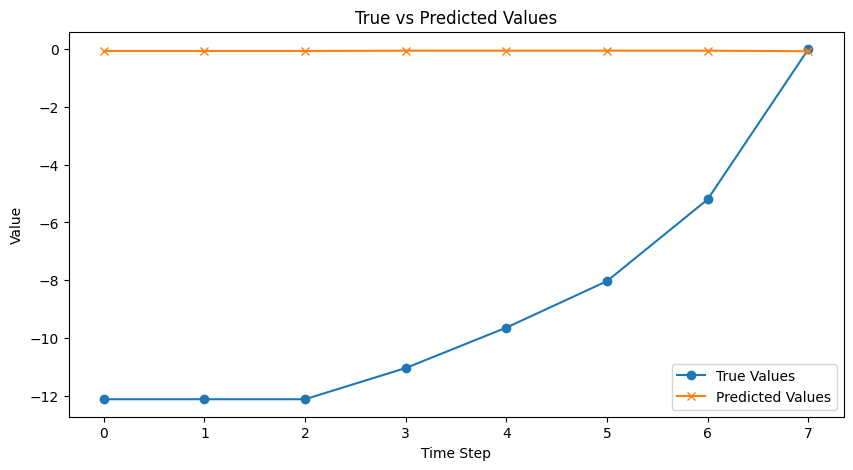

Epoch 50, TD Loss: 2.5789, MC Loss: 8.6927, Total: 9.0671     
Epoch 100, TD Loss: 3.6710, MC Loss: 3.6434, Total: 5.1721     
Epoch 150, TD Loss: 2.5176, MC Loss: 0.2945, Total: 2.5347     
Epoch 200, TD Loss: 1.9913, MC Loss: 0.3288, Total: 2.0183     
Epoch 250, TD Loss: 1.8462, MC Loss: 0.3725, Total: 1.8834     
Epoch 300, TD Loss: 1.7866, MC Loss: 0.3340, Total: 1.8176     
Epoch 350, TD Loss: 1.7159, MC Loss: 0.3601, Total: 1.7533     
Epoch 400, TD Loss: 1.6780, MC Loss: 0.3102, Total: 1.7064     
Epoch 450, TD Loss: 1.6474, MC Loss: 0.2560, Total: 1.6672     
Epoch 500, TD Loss: 1.6287, MC Loss: 0.2157, Total: 1.6429     
True Values:
[-12.12 -12.12 -12.12 -11.04  -9.64  -8.03  -5.2    0.  ]
Predicted Values:
[-12.11 -12.23 -11.92 -10.43  -9.1   -7.65  -6.05  -0.07]


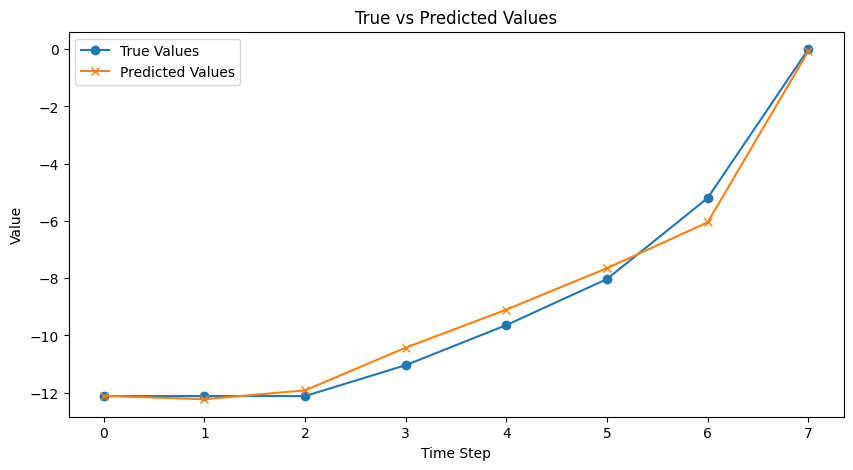

Epoch 550, TD Loss: 1.6087, MC Loss: 0.1585, Total: 1.6165     
Epoch 600, TD Loss: 1.6307, MC Loss: 0.1189, Total: 1.6350     
Epoch 650, TD Loss: 1.6159, MC Loss: 0.1539, Total: 1.6232     
Epoch 700, TD Loss: 1.6339, MC Loss: 0.1056, Total: 1.6373     
Epoch 750, TD Loss: 1.6058, MC Loss: 0.1024, Total: 1.6090     
Epoch 800, TD Loss: 1.6338, MC Loss: 0.0793, Total: 1.6357     
Epoch 850, TD Loss: 1.6107, MC Loss: 0.0844, Total: 1.6129     
Epoch 900, TD Loss: 1.6294, MC Loss: 0.0800, Total: 1.6313     
Epoch 950, TD Loss: 1.6245, MC Loss: 0.0856, Total: 1.6268     
Epoch 1000, TD Loss: 1.6246, MC Loss: 0.0895, Total: 1.6271     
True Values:
[-12.12 -12.12 -12.12 -11.04  -9.64  -8.03  -5.2    0.  ]
Predicted Values:
[-12.11 -12.23 -12.17 -10.68  -9.19  -7.61  -5.82   0.02]


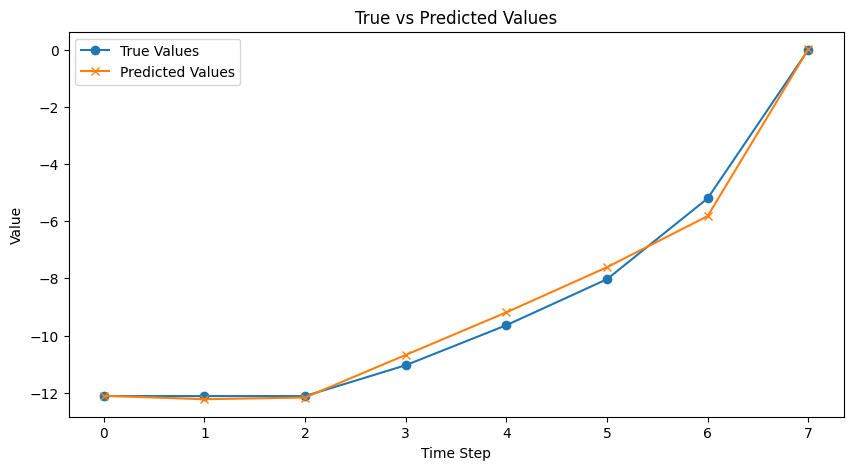

In [6]:
input_dim = episodes[0].history.shape[1]  # Number of features in the history (observations + actions)

value_RNN = ValueRNN(input_dim=input_dim, hidden_dim=64)

train(value_RNN, episodes, test_episode, value_empirical, num_epochs=1001, gamma=1.0, lr=1e-3, validate_every=500, batch_size=2500)


In [7]:
class BeliefDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, belief_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, belief_dim)

    def forward(self, x):
        # x: [B, T, D]
        x = self.fc1(x)        # works on [B, T, D]
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = nn.functional.softmax(x, dim=-1)  # [B, T, belief_dim]
        #print(f"Belief Decoder Output Shape: {x.shape}")
        return x

class linearBeliefDecoder(nn.Module):
    def __init__(self, input_dim, belief_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, belief_dim)

    def forward(self, x):
        # x: [B, T, D]
        x = self.fc(x)  # [B, T, belief_dim]
        x = nn.functional.softmax(x, dim=-1)  # Apply softmax to get probabilities
        return x

def sequence_cross_entropy(p_target, q_pred, mask=None, eps=1e-8):
    """
    Compute cross-entropy between two categorical distributions over time.

    Args:
        p_target: [B, T, C] true distribution (e.g., one-hot or soft label)
        q_pred:   [B, T, C] predicted distribution (must be softmaxed already)
        mask:     [B, T] optional mask for valid time steps (1 = valid, 0 = ignore)
        eps:      small constant to avoid log(0)

    Returns:
        Scalar cross-entropy loss
    """
    # Ensure numerical stability
    log_q = torch.log(q_pred + eps)
    
    # Element-wise cross entropy: -P * log(Q)
    cross_entropy = -torch.sum(p_target * log_q, dim=-1)  # [B, T]

    if mask is not None:
        cross_entropy = cross_entropy * mask  # mask out invalid steps
        return cross_entropy.sum() / mask.sum()
    else:
        return cross_entropy.mean()
    
    

def train_belief_decoder(belief_model, rnn_model, episodes, num_epochs=10, lr=1e-3, batch_size=1000):
    """
    Train the belief decoder using the RNN model's outputs as input.
    """

    optimizer = torch.optim.Adam(belief_model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)
    
    belief_model.train()

    histories, rewards = episodes_to_batch(episodes)
    beliefs = beliefs_to_batch(episodes)
    mask, _, _ = episodes_to_masks(episodes)

    for epoch in range(num_epochs):
        # choose "batch_size" random episodes from the dataset
        indices = np.random.choice(len(episodes), size=min(batch_size, len(episodes)), replace=False)
        
        # Get RNN outputs
        _, hidden_states = rnn_model(histories[indices], mask[indices]) # shape: [B, T, H]
        #print(f"Hidden States Shape: {hidden_states.shape}")  # Debugging output

        optimizer.zero_grad()
        
        # Get beliefs from the belief decoder
        predicted_beliefs = belief_model(hidden_states)  # shape: [B, T, belief_dim]
        
        # Calculate loss
        loss = sequence_cross_entropy(beliefs[indices], predicted_beliefs, mask[indices])
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        scheduler.step()

        print(f"Epoch {epoch+1}, Belief Decoder Loss: {loss.item():.4f}", end='\r')


In [8]:
def estimate_entropy(belief_states, base=np.e):
    eps = 1e-12  # prevent log(0)
    belief_states = np.clip(belief_states, eps, 1.0)
    log_fn = np.log if base == np.e else lambda x: np.log2(x) if base == 2 else lambda x: np.log(x) / np.log(base)
    
    entropies = -np.sum(belief_states * log_fn(belief_states), axis=1)
    return np.round(np.mean(entropies),4)

all_belief_states = []
for episode in episodes:
    all_belief_states.append(np.array(episode.belief_states))
all_belief_states = np.concatenate(all_belief_states, axis=0)

print("Average Entropy of Belief States:", estimate_entropy(all_belief_states, base=np.e))


Average Entropy of Belief States: 0.4225


In [9]:
belief_decoder = BeliefDecoder(input_dim=64, hidden_dim=64, belief_dim=cliff.n * cliff.m)
train_belief_decoder(belief_decoder, value_RNN, episodes, num_epochs=1001, lr=1e-3, batch_size=2500)

In [10]:
linear_belief_decoder = linearBeliefDecoder(input_dim=64, belief_dim=cliff.n * cliff.m)
train_belief_decoder(linear_belief_decoder, value_RNN, episodes, num_epochs=1001, lr=1e-3, batch_size=2500)

Validating Belief Decoder:
(8, 12)


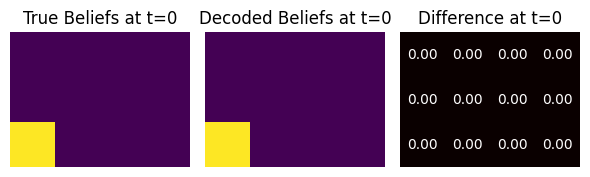

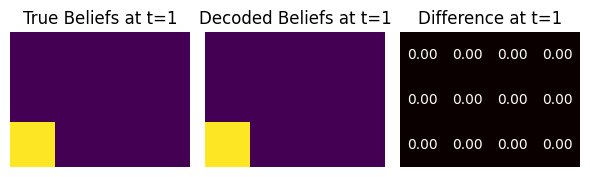

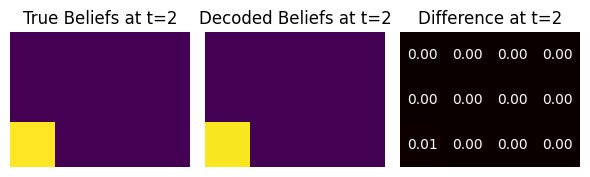

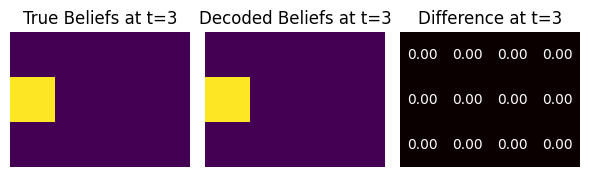

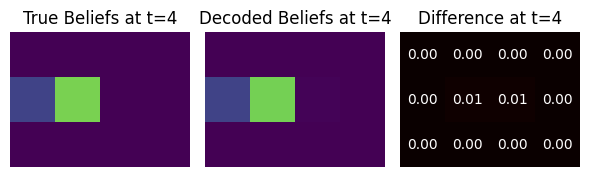

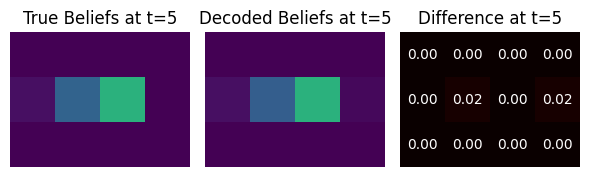

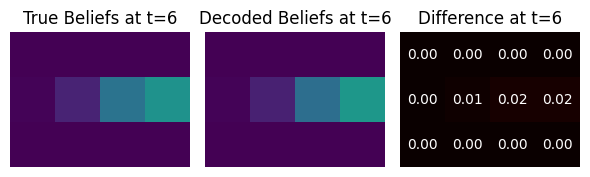

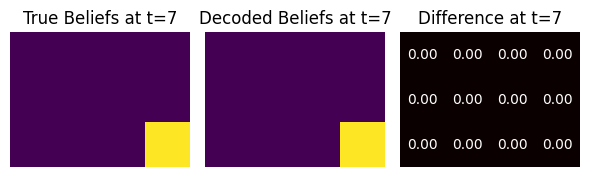

Validating Linear Belief Decoder:
(8, 12)


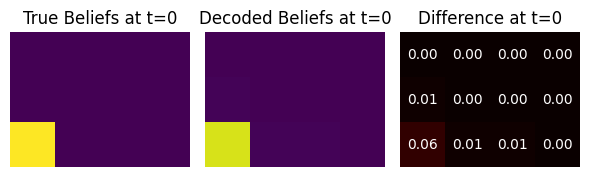

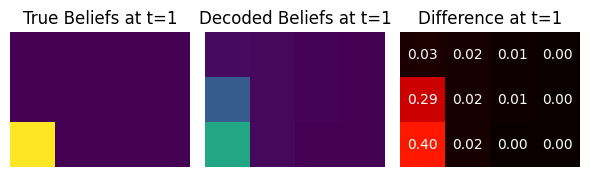

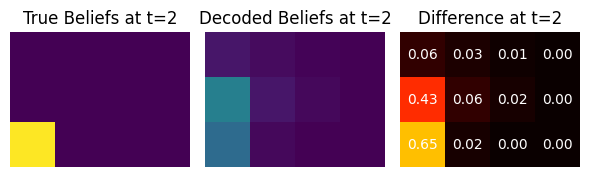

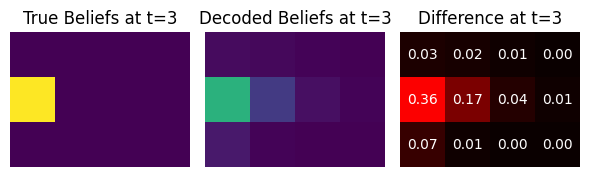

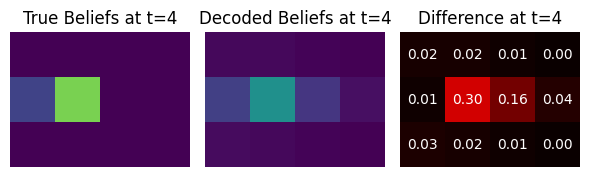

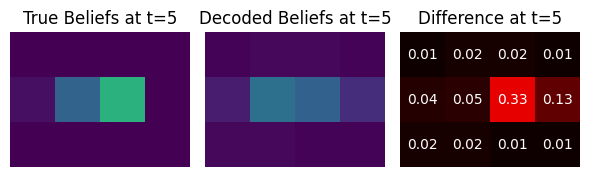

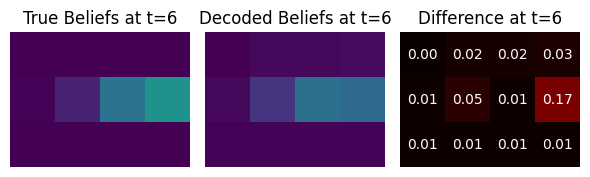

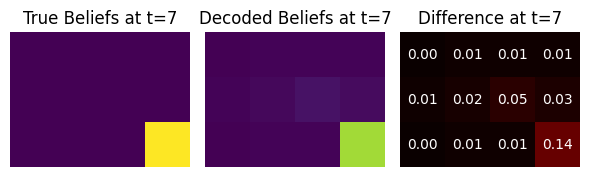

In [ ]:
def evaluate_episode(value_model, belief_model, episode):
    value_model.eval()  # switch to eval mode
    belief_model.eval()  # switch to eval mode

    with torch.no_grad():
        history = torch.tensor(episode.history, dtype=torch.float32).unsqueeze(0)  # shape: [1, T, D]
        length = [history.shape[1]]  # length = [T]
        mask = torch.ones((1, history.shape[1]), dtype=torch.float32)

        _, hidden = value_model(history, mask)  # shape: [1, T]
        predicted_beliefs = belief_model(hidden)
        
        return predicted_beliefs.numpy()
    
def validate(value_model, belief_model, test_episode):
    true_beliefs = test_episode.belief_states
    true_beliefs = np.round(true_beliefs, 2)

    beliefs = evaluate_episode(value_model, belief_model, test_episode)
    beliefs = np.round(beliefs, 2)[0]

    for t in range(len(true_beliefs)):
        fig, axs = plt.subplots(1, 3, figsize=(6, 3))
        # true beliefs
        axs[0].imshow(true_beliefs[t].reshape((cliff.n, cliff.m)), cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
        axs[0].set_title(f"True Beliefs at t={t}")
        axs[0].axis('off')
        axs[0].invert_yaxis()  # Invert y-axis to match the grid orientation
        # predicted beliefs
        axs[1].imshow(beliefs[t].reshape((cliff.n, cliff.m)), cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
        axs[1].set_title(f"Decoded Beliefs at t={t}")
        axs[1].axis('off')
        axs[1].invert_yaxis()
        # Compute and display the difference
        diff_data = np.abs(true_beliefs[t] - beliefs[t]).reshape((cliff.n, cliff.m))
        axs[2].imshow(diff_data, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
        axs[2].set_title(f"Difference at t={t}")
        axs[2].axis('off')
        axs[2].invert_yaxis()

        # Annotate the cells in the third subplot
        for i in range(cliff.n):
            for j in range(cliff.m):
                axs[2].text(j, i, f"{diff_data[i, j]:.2f}", ha='center', va='center', color='white')

        plt.tight_layout()
        plt.show()


print("Validating Belief Decoder:")
validate(value_RNN, belief_decoder, test_episode)

print("Validating Linear Belief Decoder:")
validate(value_RNN, linear_belief_decoder, test_episode)